In [1]:
import os
from datetime import datetime  
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt
import pandas as pd
from src.thermo_calculations.equilibrium_constants import keq_from_kegg_cache

# some SBML model
# modelfile = '/gscratch/cheme/dalba/repos/ECFERS/models/b2.xml'
modelfile = '/gscratch/cheme/dalba/repos/ECFERS/models/model_placeholder.sbml' # filled nan values with 1 for now

r = te.loadSBMLModel(modelfile)
# r = te.loadSBMLModel(r.getParamPromotedSBML(r.getSBML()))

# bin_model = 'model.b'
# r.saveState(bin_model)
# r.exportToSBML(modelfile[:-3]+'sbml')

parameter_values = r.getGlobalParameterValues()

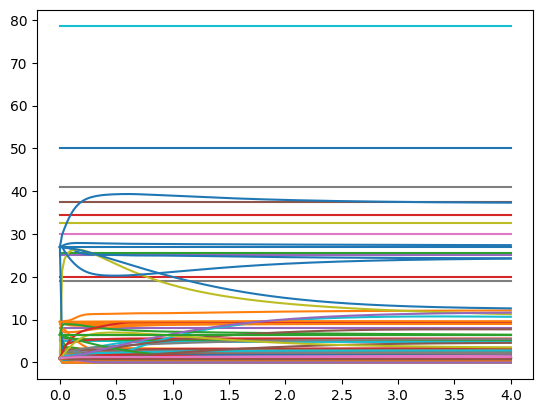

In [2]:
# new_parameter_values = parameter_values*np.random.uniform(0, 1, len(parameter_values))
# r.model.setGlobalParameterValues(parameter_values)

result = r.simulate(0, 4, 200)
r.reset()
plt.plot(result[:,0], result[:,1:]);
#plt.yscale('log')

In [3]:
class SBMLGlobalFit:

    def __init__(self, model, data, parameter_labels, lower_bounds, upper_bounds, settings, logKeq_r, variables = {}, scale = False, n_constraints = 0):
        self.model = model
        self.data = data
        self.parameter_labels = parameter_labels # only the ones that are going to be fitted
        self.settings = settings
        self.upperb = upper_bounds
        self.lowerb = lower_bounds
        self.scale = scale
        self.n_constraints = n_constraints
        self.variables = variables # dict of labels and values
        self.logKeq_r = logKeq_r

    def fitness(self, x):
        if self.scale: x = self._unscale(x)
        r, results = self._simulate(x)
        obj = self._residual(results,self.data)
        if self.n_constraints > 0:
            constraints = self._haldane(r)
            return [obj, *constraints]
        else:
            return [obj]
            
    def _simulate(self, x):
        from roadrunner import Config, RoadRunner
        Config.setValue(Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, False)
        Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, False) 
        Config.setValue(Config.LLJIT_OPTIMIZATION_LEVEL, 4)

        id = str(os.getpid())
        try:
            r = RoadRunner()
            r.loadState('model_state_'+id+'.b')
        except Exception as e:
            print(e)
            r = te.loadSBMLModel(self.model)
            r.saveState('model_state_'+id+'.b')

        # r = te.loadSBMLModel(self.model)
        # update parameters
        for label, value in zip(self.parameter_labels,x):
            try:
                r[label] = value
            except Exception as e:
                print(e)
                return r, self.data*(-np.inf)

        # set any variable
        for label, value in self.variables.items():
            try:
                r[label] = value
            except Exception as e:
                print(e)
                return r, self.data*(-np.inf)
        try:
            results = r.simulate(**self.settings['simulation'])[:,1:].__array__()
        except:
            results = self.data*(-np.inf)

        return r, results
    
    # def _residual(self,results,data,points):
    #     md = (np.nanmax(data,1,keepdims=True)-np.nanmin(data,1,keepdims=True))/2
    #     mr = (np.nanmax(results,1,keepdims=True)-np.nanmin(results,1,keepdims=True))/2
    #     denom = np.ones(data.shape)
    #     return [np.nansum(((data-results)/(points*(md**2+mr**2)**0.5*denom))**2)]

    def _residual(self,results,data):
        cols = self.settings['fit_to_cols']
        rows = self.settings['fit_to_rows']

        error = (data[:,cols][rows,:]-results[:,cols][rows,:])
        RMSE = np.sqrt(np.nansum(error**2, axis=0)/len(rows))
        NRMSE = RMSE/(np.nanmax(data[:,cols][rows,:], axis=0) - np.nanmin(data[:,cols][rows,:], axis=0) + 1e6)
        return np.nansum(NRMSE)
    
    def _unscale(self, x):
        return self.lowerb + (self.upperb - self.lowerb) * x
    
    def _scale(self, x):
        return (x - self.lowerb) / (self.upperb - self.lowerb)

    def _haldane(self, r):
        matrix = r.getFullStoichiometryMatrix();
        species_labels = np.array(matrix.rownames)
        metabolites_index = ['EC' not in label for label in species_labels]
        metabolites_labels = species_labels[metabolites_index]
        reaction_labels = np.array(matrix.colnames)
        stoich = matrix[metabolites_index,:]

        kms = np.zeros(shape=stoich.shape)
        for i in range(stoich.shape[0]):
            for j in range(stoich.shape[1]):
                m_id = metabolites_labels[i]
                r_id = reaction_labels[j]
                if stoich[i,j] != 0:
                    kms[i,j] = stoich[i,j]*np.log(r['Km_'+m_id+'_'+r_id])
        
        nlogKm_r = kms.sum(axis=0)
        logKcats_r = np.array([np.log(r['Kcat_F_'+r_id]/r['Kcat_R_'+r_id]) for r_id in r.getReactionIds()])
        logKeq_r = self.logKeq_r # may be a better way to pass this
        return (logKeq_r-logKcats_r-nlogKm_r)/logKeq_r

    def get_bounds(self):
        if self.scale:
            lowerb = [0 for i in self.lowerb]
            upperb = [1 for i in self.upperb]
        else:
            upperb = self.upperb
            lowerb = self.lowerb    
        return (lowerb, upperb)
    
    def get_name(self):
        return 'Global Fitting of Multiple SBML Models'

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x),x)
    
    def get_nec(self):
        return self.n_constraints


In [4]:
# pick a number of data points to fit to
settings = {'fit_to_cols':list(np.random.choice(r.getNumFloatingSpecies(),(r.getNumFloatingSpecies()//1),replace=False))}
settings['fit_to_rows'] = list(map(int, np.linspace(0,199-1,10)))
settings['simulation'] = {'start':0, 'end':4, 'points':200}

# get all the parameters that can vary
kinetics_labels = [p for p in r.getGlobalParameterIds() if np.any([k in p for k in ['Km','Kcat','Ki','G1']])]
species_labels = np.array(r.getFullStoichiometryMatrix().rownames);
metabolites_index = ['EC' not in label for label in species_labels]
metabolites_labels = species_labels[metabolites_index]
parameter_labels = kinetics_labels + list(metabolites_labels)
parameter_labels.append('rel0') # what are good bounds for this?

# make upper and lower bounds
upper = np.array([r[i]*10 for i in kinetics_labels] + [r[i]*10 for i in species_labels] + [1000])
lower = np.array([r[i]/10 for i in kinetics_labels] + [r[i]/10 for i in species_labels] + [10])

# define variables that don't change (dilution factor, biosynthesis metabolites, which enzymes are present)

logKeq_r = np.log([keq_from_kegg_cache(i)['value'] for i in pd.read_csv('src/frenda_brenda/Examples/Reaction_placeholder.csv', index_col=0)['Reaction ID'].values]);

/tmp/ipykernel_428/1429532076.py:20: RuntimeWarning:

divide by zero encountered in log



In [5]:
myprob = SBMLGlobalFit(model = modelfile, data = result[:,1:].__array__(), parameter_labels=parameter_labels, lower_bounds=lower, upper_bounds=upper, logKeq_r=logKeq_r, settings=settings, scale=True)
prob = pg.problem(myprob)
prob.c_tol = 1

In [6]:
udbfe = pg.ipyparallel_bfe()
udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'})
mybfe = pg.bfe(udbfe)

# pick parameters based on this thesis
# https://repository.up.ac.za/handle/2263/66233#:~:text=The%20thesis%20shows%20that%20the,empirical%20tests%20and%20theoretical%20reasoning.
algos = []
pops = []
for i in range(5):
    a = pg.pso_gen(gen=10,omega=0.95, eta1=0.25, eta2=0.25, max_vel=0.01, variant=5, neighb_type=2, neighb_param=4)
    a.set_bfe(mybfe)
    algo = pg.algorithm(a)
    algo.set_verbosity(1)
    algos.append(algo)
    pops.append(pg.population(prob, size = 0))

In [7]:
import ipyparallel as ipp
client = ipp.Client(profile='cheme-ecfers')
len(client[:])


720

In [54]:
def make_file():
    from roadrunner import Config, RoadRunner
    Config.setValue(Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, False)
    Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, False) 
    Config.setValue(Config.LLJIT_OPTIMIZATION_LEVEL, 4)
    id = str(os.getpid())
    r = te.loadSBMLModel(modelfile)
    r.saveState('model_state_'+id+'.b')
    return True

In [56]:
check_file()

True

In [8]:
def check_file():
    from roadrunner import Config, RoadRunner
    Config.setValue(Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, False)
    Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, False) 
    Config.setValue(Config.LLJIT_OPTIMIZATION_LEVEL, 4)

    id = str(os.getpid())
    r = RoadRunner()
    r.loadState('model_state_'+id+'.b')
    return True


In [36]:
def d():
    from roadrunner import Config, RoadRunner
    Config.setValue(Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, False)
    Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, False) 
    Config.setValue(Config.LLJIT_OPTIMIZATION_LEVEL, 4)
    id = str(os.getpid())
    r = te.loadSBMLModel(modelfile)

    return True

In [9]:
client[:].apply_sync(check_file)   

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [18]:
mybfe

BFE name: Ipyparallel batch fitness evaluator
	C++ class name: pybind11::object

	Thread safety: none

Extra info:
	Queue status:
	
	(unassigned, 0)
	(0, {'queue': 0, 'completed': 11, 'tasks': 0})
	(1, {'queue': 0, 'completed': 11, 'tasks': 0})
	(2, {'queue': 0, 'completed': 11, 'tasks': 0})
	(3, {'queue': 0, 'completed': 11, 'tasks': 0})
	(4, {'queue': 0, 'completed': 11, 'tasks': 0})
	(5, {'queue': 0, 'completed': 11, 'tasks': 0})
	(6, {'queue': 0, 'completed': 11, 'tasks': 0})
	(7, {'queue': 0, 'completed': 11, 'tasks': 0})
	(8, {'queue': 0, 'completed': 11, 'tasks': 0})
	(9, {'queue': 0, 'completed': 11, 'tasks': 0})
	(10, {'queue': 0, 'completed': 11, 'tasks': 0})
	(11, {'queue': 0, 'completed': 11, 'tasks': 0})
	(12, {'queue': 0, 'completed': 11, 'tasks': 0})
	(13, {'queue': 0, 'completed': 11, 'tasks': 0})
	(14, {'queue': 0, 'completed': 11, 'tasks': 0})
	(15, {'queue': 0, 'completed': 11, 'tasks': 0})
	(16, {'queue': 0, 'completed': 11, 'tasks': 0})
	(17, {'queue': 0, 'complete

In [62]:
total_nodes = 40*18
init_std = 0.17

for p in pops:
    xs = (np.expand_dims(myprob._scale(lower*10),-1)@np.ones((1,total_nodes))*(1+np.random.normal(0, init_std,(len(lower),total_nodes)))).T + 0.1
    fs = udbfe._view.map_sync(myprob.fitness,xs)
    list(map(p.push_back, xs, fs))

In [10]:
import pickle

with open('logs.dat', 'rb') as file:
    logs = pickle.load(file)

with open('checkpoint.dat', 'rb') as file:
    pops = pickle.load(file)

In [97]:
import pickle
now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")
# logs = [[] for _ in range(5)]
for i in range(50):
    print(now() + ' - Starting evolution ' + str(i))
    pops = [a.evolve(p) for a,p in zip(algos,pops)]
    print(now() + ' - Evolution done. Best fitness: ' + str(np.min([p.champion_f for p in pops])))

    for i,a in enumerate(algos):
        logs[i].append(np.array(a.extract(pg.pso_gen).get_log()))

    with open('logs.dat', 'wb') as file:
        pickle.dump(logs, file)

    with open('checkpoint.dat', 'wb') as file:
        pickle.dump(pops, file)

    if np.min([p.champion_f for p in pops]) < prob.extract(SBMLGlobalFit)._residual(result[:,1:].__array__()*(1.055),result[:,1:].__array__()):
        break
    
results = [np.concatenate(l,axis=0) for l in logs]

23-02-2024, 17:27:00 - Starting evolution 0

   Gen:        Fevals:         gbest:     Mean Vel.:    Mean lbest:    Avg. Dist.:
      1            720    0.000646397     0.00502706      0.0007785        3.27623
      2           1440    0.000645747     0.00480023    0.000775345        3.26969
      3           2160    0.000645747     0.00405348     0.00077201        3.26735
      4           2880    0.000645747     0.00243201    0.000768137        3.26708
      5           3600    0.000645747     0.00237375    0.000763068        3.27035
      6           4320    0.000642292     0.00366708    0.000756708        3.27882
      7           5040    0.000639416      0.0043682    0.000750036        3.29385
      8           5760    0.000634284     0.00455374    0.000743842        3.31317
      9           6480    0.000628531     0.00440092    0.000738051        3.33651
     10           7200    0.000620767     0.00402523    0.000732584        3.36191
Exit condition -- generations = 10

   Gen

Text(0.5, 1.0, 'Convergence curves (n=5, independent; p=720) for fitting PLACEHOLDER')

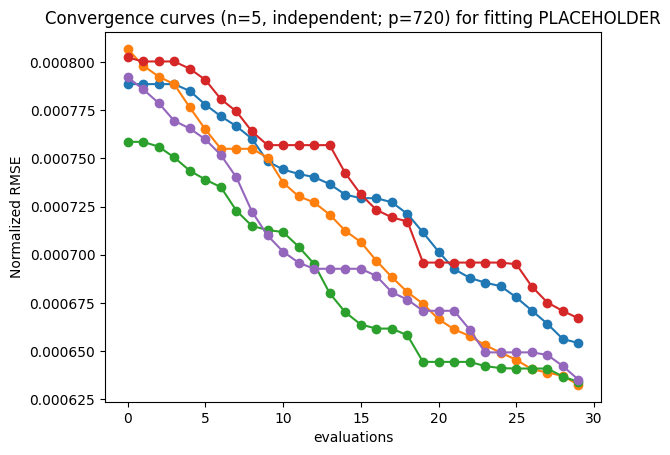

In [96]:
[plt.plot(res[:,2],'o-') for res in results]
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Normalized RMSE')
plt.xlabel('evaluations')
plt.title('Convergence curves (n=5, independent; p=720) for fitting PLACEHOLDER')  

(array([ 4.,  5., 22., 20., 17., 13., 18., 19., 13., 13.]),
 array([0.00919159, 0.04162391, 0.07405623, 0.10648854, 0.13892086,
        0.17135318, 0.2037855 , 0.23621781, 0.26865013, 0.30108245,
        0.33351477]),
 <BarContainer object of 10 artists>)

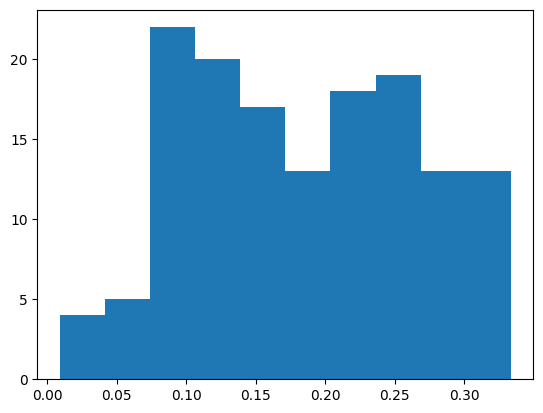

In [15]:
plt.hist(pops[0].get_x()[4,:])

Could not set value for cadp, as it is defined by an assignment rule, and can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData*, int, double), rrllvm::LLVMExecutableModel::GetNameFuncPtr, size_t, const int*, const double*, bool)
Could not set value for camp, as it is defined by an assignment rule, and can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData*, int, double), rrllvm::LLVMExecutableModel::GetNameFuncPtr, size_t, const int*, const double*, bool)
Could not set value for catp, as it is defined by an assignment rule, and can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData*, int, double), rrllvm::LLVMExecutableModel::GetNameFuncPtr, size_t, const int*, const double*, bool)
Could not set value for cnad, as it is defined by an assignment rule, and can not be set independently., at int rrllvm::LLVMExecutableModel::setValu

(-0.2811024511151514, 5.94649432923366)

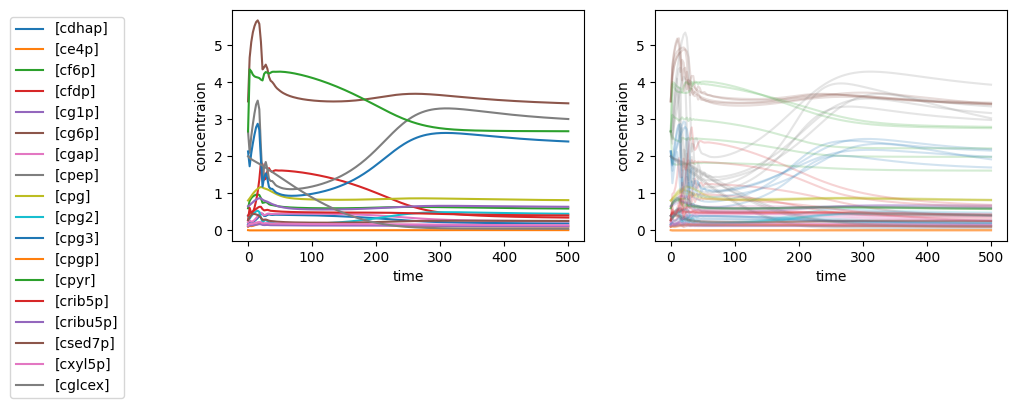

In [17]:
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
plt.figure(figsize=(10,3))
a = plt.subplot(1,2,1)
a.plot(result['time'],result[:,1:].__array__())
a.legend(result.colnames[1:], bbox_to_anchor=(-0.65, 1), loc='upper left' )
a.set_xlabel('time')
a.set_ylabel('concentraion')
#a.set_yscale('log')

b = plt.subplot(1,2,2)
mean_result = result*0
for k,c in enumerate([p.champion_x for p in pops]):
    r.resetToOrigin()
    for i,p in enumerate(myprob._unscale(c)):
        try:
            r[parameter_labels[i]] = p
        except Exception as e:
            print(e)
            pass
    try:
        result2 = r.simulate(**settings['simulation'])
    except Exception as e:
        print(k)
        print(e)
        result2 = result*0
    mean_result += result2
    
    b.set_prop_cycle(color=colors)
    b.plot(result['time'], result2[:,1:].__array__(), alpha = 0.2)

b.set_prop_cycle(color=colors)
#b.plot(result['time'][settings['fit_to_rows']], (mean_result[:,1:].__array__()/8)[:,settings['fit_to_cols']][settings['fit_to_rows'],:],'o')
b.set_xlabel('time')
b.set_ylabel('concentraion')
#b.set_yscale('log')
b.set_ylim(a.get_ylim())